In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [32]:
"""# Importing Libraries"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from scipy.ndimage import zoom
from skimage.measure import block_reduce
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [4]:
"""# Loading Data"""

path = "drive/MyDrive/Cog_DataSets/testing/"
# path = "drive/MyDrive/Colab Notebooks/CogAge/Datasets/testing/"
test_acc = np.load(path+"testAccelerometer.npy")
test_grav = np.load(path+"testGravity.npy")
test_gyro = np.load(path+"testGyroscope.npy")
test_jinsAcc = np.load(path+"testJinsAccelerometer.npy")
test_jinsGyro = np.load(path+"testJinsGyroscope.npy")
test_Label =np.load(path+"testLabels.npy") 
test_linAcc = np.load(path+"testLinearAcceleration.npy")
test_MsAcc = np.load(path+"testMSAccelerometer.npy")
test_MsGyro = np.load(path + "testMSGyroscope.npy")
test_MsMag = np.load(path+"testMagnetometer.npy")
# test_acc

path = "drive/MyDrive/Cog_DataSets/training/"
# path = "drive/MyDrive/Colab Notebooks/CogAge/Datasets/training/"
train_acc = np.load(path+"trainAccelerometer.npy")
train_grav = np.load(path+"trainGravity.npy")
train_gyro = np.load(path+"trainGyroscope.npy")
train_jinsAcc = np.load(path+"trainJinsAccelerometer.npy")
train_jinsGyro = np.load(path+"trainJinsGyroscope.npy")
train_Label =np.load(path+"trainLabels.npy") 
train_linAcc = np.load(path+"trainLinearAcceleration.npy")
train_MsAcc = np.load(path+"trainMSAccelerometer.npy")
train_MsGyro = np.load(path + "trainMSGyroscope.npy")
train_MsMag = np.load(path+"trainMagnetometer.npy")
# print(train_Label.shape)

In [5]:
"""# Reshape and stack Data Before Fitting to Model"""
# changing shape of sensor data to (#,400,3)
# downsample
train_acc_reshaped = block_reduce(train_acc, block_size=(1, 2, 1), func=np.mean)
train_gyro_reshaped = block_reduce(train_gyro, block_size=(1, 2, 1), func=np.mean)
train_grav_reshaped = block_reduce(train_grav, block_size=(1, 2, 1), func=np.mean)
train_linAcc_reshaped = block_reduce(train_linAcc, block_size=(1, 2, 1), func=np.mean)
# upsample
train_MsAcc_reshaped = resize(train_MsAcc, (2284, 400, 3), mode='edge')
train_MsGyro_reshaped = resize(train_MsGyro, (2284, 400, 3), mode='edge')
# upsample
train_MsMag_reshaped = np.repeat(train_MsMag, 2, axis=1)
train_jinsAcc_reshaped = np.repeat(train_jinsAcc, 5, axis=1)
train_jinsGyro_reshaped = np.repeat(train_jinsGyro, 5, axis=1)

test_acc_reshaped = block_reduce(test_acc, block_size=(1, 2, 1), func=np.mean)
test_gyro_reshaped = block_reduce(test_gyro, block_size=(1, 2, 1), func=np.mean)
test_grav_reshaped = block_reduce(test_grav, block_size=(1, 2, 1), func=np.mean)
test_linAcc_reshaped = block_reduce(test_linAcc, block_size=(1, 2, 1), func=np.mean)
test_MsAcc_reshaped = resize(test_MsAcc, (2288, 400, 3), mode='edge')
test_MsGyro_reshaped = resize(test_MsGyro, (2288, 400, 3), mode='edge')
test_MsMag_reshaped = np.repeat(test_MsMag, 2, axis=1)
test_jinsAcc_reshaped = np.repeat(test_jinsAcc, 5, axis=1)
test_jinsGyro_reshaped = np.repeat(test_jinsGyro, 5, axis=1)

In [6]:
# all data of shape #,400,3
# adding all relative data.
# Mobile training accelerometer + Mobile testing accelerometer data
train_acc_reshaped = np.append(train_acc_reshaped,test_acc_reshaped, axis=0)
train_gyro_reshaped = np.append(train_gyro_reshaped,test_gyro_reshaped, axis=0)
train_grav_reshaped = np.append(train_grav_reshaped,test_grav_reshaped, axis=0)
train_linAcc_reshaped = np.append(train_linAcc_reshaped,test_linAcc_reshaped, axis=0)
train_MsAcc_reshaped = np.append(train_MsAcc_reshaped,test_MsAcc_reshaped, axis=0)
train_MsGyro_reshaped = np.append(train_MsGyro_reshaped,test_MsGyro_reshaped, axis=0)
train_MsMag_reshaped = np.append(train_MsMag_reshaped,test_MsMag_reshaped, axis=0)
train_jinsAcc_reshaped = np.append(train_jinsAcc_reshaped,test_jinsAcc_reshaped, axis=0)
train_jinsGyro_reshaped = np.append(train_jinsGyro_reshaped,test_jinsGyro_reshaped, axis=0)


print("Shape of all sensors after up/down sample... ", train_acc_reshaped.shape, train_gyro_reshaped.shape, train_grav_reshaped.shape, train_linAcc_reshaped.shape
                       , train_MsAcc_reshaped.shape, train_MsGyro_reshaped.shape, train_MsMag_reshaped.shape,
                       train_jinsAcc_reshaped.shape, train_jinsGyro_reshaped.shape)

# all data of shape 4572,400,3
# 4572 = 2284(training) + 2288(testing)


# stack
all_data = np.stack([train_acc_reshaped, train_gyro_reshaped, train_grav_reshaped, train_linAcc_reshaped
                       , train_MsAcc_reshaped, train_MsGyro_reshaped, train_MsMag_reshaped,
                       train_jinsAcc_reshaped, train_jinsGyro_reshaped], axis=-1)

all_Label = np.append(train_Label, test_Label, axis=-1)

Shape of all sensors after up/down sample...  (4572, 400, 3) (4572, 400, 3) (4572, 400, 3) (4572, 400, 3) (4572, 400, 3) (4572, 400, 3) (4572, 400, 3) (4572, 400, 3) (4572, 400, 3)


In [7]:
# 70% training data + labels
train_data = all_data[: int(all_data.shape[0]*0.6)]
# 30% testing data + labels
test_data = all_data[int(all_data.shape[0]*0.6):]
train_labels = all_Label[: int(all_Label.shape[0]*0.6)]
test_labels = all_Label[int(all_Label.shape[0]*0.6):]

print("\nShape of training and testin data + labels...\n")
print(train_data.shape, test_data.shape)
print(train_labels.shape, test_labels.shape)


Shape of training and testin data + labels...

(2743, 400, 3, 9) (1829, 400, 3, 9)
(2743,) (1829,)


In [8]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

print("Shape of training + validation Data")
print(np.shape(x_train), np.shape(y_train))

y_train = to_categorical(y_train, num_classes=55)
y_val = to_categorical(y_val, num_classes=55)

print("Shape of training + validation Labels")
print(np.shape(y_train), np.shape(y_val))

Shape of training + validation Data
(2194, 400, 3, 9) (2194,)
Shape of training + validation Labels
(2194, 55) (549, 55)


In [34]:
# HYPER PARAMTERS

# Activation function of the convolutional layer(s)
activationConv = 'relu'

# Parameters of the dense layer
activationMLP = 'relu'
inputMLP = 2500

# Training parameters
batchSize = 400
numberOfEpochs = 30
learningRate = 0.001

input_shape = (400,3,9)
nbClasses = 55

In [44]:
from tensorflow.keras.regularizers import l2

#-------------------------------------------------------------------------------------------------------
# normMlp1: define a batch normalization + one hidden layer MLP
#-------------------------------------------------------------------------------------------------------
def normMlp1(
    inputShape,
    inputMLP,
    activationMLP,
    nbClasses,
    withSoftmax=True):

    model = Sequential()

    model.add(BatchNormalization(input_shape=inputShape))

    model.add(Flatten())
    model.add(Dense(inputMLP, activation=activationMLP, kernel_regularizer=l2(0.01)))
    model.add(Dense(inputMLP, activation=activationMLP, kernel_regularizer=l2(0.01)))
    #model.add(Dropout(0.5))

    # Softmax layer
    if withSoftmax:
        model.add(Dense(nbClasses, activation='softmax'))

    # Return the model
    return model

In [45]:
model = normMlp1(inputShape=input_shape,
                 inputMLP=inputMLP,
                 activationMLP=activationMLP,
                 nbClasses=nbClasses)


model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=learningRate),
    metrics=['accuracy']
)

train_loss = []
val_loss = []

In [46]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 400, 3, 9)        36        
 hNormalization)                                                 
                                                                 
 flatten_6 (Flatten)         (None, 10800)             0         
                                                                 
 dense_13 (Dense)            (None, 2500)              27002500  
                                                                 
 dense_14 (Dense)            (None, 2500)              6252500   
                                                                 
 dense_15 (Dense)            (None, 55)                137555    
                                                                 
Total params: 33,392,591
Trainable params: 33,392,573
Non-trainable params: 18
_________________________________________

In [53]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=numberOfEpochs,
    batch_size=batchSize
)

Epoch 1/30
6/6 [==============================] - 9s 2s/step - loss: 1.0329 - accuracy: 0.9850 - val_loss: 2.1162 - val_accuracy: 0.6812
Epoch 2/30
6/6 [==============================] - 8s 1s/step - loss: 1.0142 - accuracy: 0.9809 - val_loss: 2.1007 - val_accuracy: 0.7049
Epoch 3/30
6/6 [==============================] - 9s 1s/step - loss: 0.9935 - accuracy: 0.9840 - val_loss: 2.0307 - val_accuracy: 0.7067
Epoch 4/30
6/6 [==============================] - 9s 2s/step - loss: 0.9924 - accuracy: 0.9731 - val_loss: 1.9945 - val_accuracy: 0.6940
Epoch 5/30
6/6 [==============================] - 8s 1s/step - loss: 0.9622 - accuracy: 0.9790 - val_loss: 2.0077 - val_accuracy: 0.6995
Epoch 6/30
6/6 [==============================] - 9s 1s/step - loss: 0.9488 - accuracy: 0.9772 - val_loss: 1.9659 - val_accuracy: 0.6976
Epoch 7/30
6/6 [==============================] - 9s 2s/step - loss: 0.9227 - accuracy: 0.9781 - val_loss: 1.9547 - val_accuracy: 0.6995
Epoch 8/30
6/6 [=========================

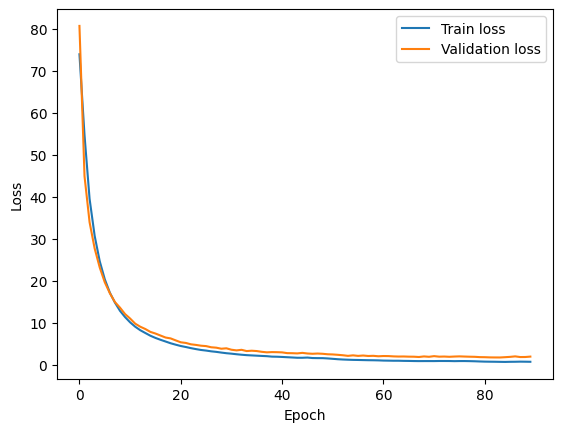

In [54]:
train_loss += history.history['loss']
val_loss += history.history['val_loss']

# plot the graph
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
estimatedLabels = np.argmax(model.predict(test_data),axis=-1)
estimatedLabels = estimatedLabels.flatten()

accuracy = accuracy_score(test_labels,estimatedLabels)
weightedF1 = f1_score(test_labels,estimatedLabels,average='weighted')
averageF1 = f1_score(test_labels,estimatedLabels,average='macro')
#confMat = confusion_matrix(testingLabels,estimatedLabels,labels=labelsTable.values())
allF1Scores = f1_score(test_labels,estimatedLabels,average=None)

# Print results
print('   Test accuracy = %.2f %%' % (accuracy*100))
print('   Weighted F1-score = %.4f' % (weightedF1))
print('   Average F1-score = %.4f' % (averageF1))
# print('   All F1-scores:')
# print(allF1Scores)
print('-------------------------------------------------------')

58/58 [==============================] - 2s 40ms/step
   Test accuracy = 58.23 %
   Weighted F1-score = 0.5787
   Average F1-score = 0.5783
-------------------------------------------------------
